## COVID-19 PAKISTAN Data Modeling

### Packages

In [1]:
import numpy as np
import pandas as pd
import datetime

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

COVID-19 Data Modeling for Pakistan

#### Province wise Data Model

In [3]:
fulltable_pr = pd.read_excel('F:/Data Sets/COVID-19/Pakistan/time series/COVID-19_DATA.xlsx',
                           sheet_name='TimeSeries_KeyIndicators')
fulltable_pr = fulltable_pr.drop(['Discharged'], axis=1).groupby(['Date','Region']).sum().reset_index()
fulltable_pr['Date'] = pd.to_datetime(fulltable_pr['Date'])
fulltable_pr = fulltable_pr.rename(columns={"Cumulative  Test positive": "Confirmed", "Expired": "Deaths","Discharged": "Recovered"}) 

In [4]:
# latest condensed
full_latest = fulltable_pr[fulltable_pr['Date'] == max(fulltable_pr['Date'])].reset_index()
full_table_grouped = full_latest.groupby('Region')['Confirmed', 'Deaths'].sum().reset_index()

In [5]:
temp_f = full_table_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f[['Region', 'Confirmed', 'Deaths']]
temp_f = temp_f.reset_index(drop=True)

temp_f.style.background_gradient(cmap="Blues", subset=['Confirmed'])\
            .background_gradient(cmap="Reds", subset=['Deaths'])

,Region,Confirmed,Deaths
0,Punjab,5827,100
1,Sindh,5291,92
2,KP,2160,114
3,Balochistan,915,14
4,GB,330,3
5,ICT,297,4
6,AJK,65,0


### Model: Forecast using Gradient with Diffusion

I am using a model from a __marketing__ paper by __Emmanuelle Le Nagard__ and __Alexandre Steyer__, that attempts to reflect the social structure of a __diffusion__ process. Their application was the diffusion of innovations, not epidemics. However, there are commonalities in both domains, as the number of contacts each infected person / innovation adopter has seems relevant. It also has the added benefit to allow fitting parameters to the beginning of a time series.

The model is also sensitive to when we define the origin of time for the epidemic process. Here, I just took the first point of the time series available.


In [6]:
import math

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [7]:
model_index = 0

def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, model_index]) ** 2
    return math.sqrt(r) 

We need to explore the 3d parameter space to find a minimum, using gradient descent. There are a number of algorithms to do that in scipy.optimize, I stopped at the first one that seemed to work. Generalized Reduced Gradient as in Excel solver also works.

In [8]:
province = 'Punjab'

In [9]:
def display_fit_pr(df, opt_confirmed, opt_deaths, ax):
    model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = model_x[-1]
            if (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
                    
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                
                
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['Model-Confirmed', 'Model-Deaths']
    plot_color = ['#99990077', '#FF000055', '#999900FF', '#FF0000FF']

    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)

In [10]:
def display_extended_curve_pr(df, opt_confirmed, opt_deaths, ax):
    start_date = df.index[0]
    n_days = len(df) + 40
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                    
                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths']

    plot_color = ['#99990077', '#FF000055', '#999900FF', '#FF0000FF']
   
    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)
    


In [11]:
def display_extended_table_pr(df):
    start_date = df.index[0]
    n_days = len(df) + 40
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    global model_index
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths']
    return extended_model_sim

In [12]:
from scipy.optimize import minimize
def opt_display_model_pr(df, stats):
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    global model_index
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    if min(opt_confirmed) > 0:
        stats.append([province, *opt_confirmed, *opt_deaths])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit_pr(df, opt_confirmed, opt_deaths, ax1)
        ax2 = plt.subplot(222)
        display_extended_curve_pr(df, opt_confirmed, opt_deaths, ax2)
        plt.show()

In [13]:
def get_time_series_province_pr(province):
    global fulltable_pr
    df = fulltable_pr[(fulltable_pr['Region'] == province)]
    return df.set_index('Date')[['Confirmed', 'Deaths']]

Test Provincial level predictions

### Punjab

In [14]:
df = get_time_series_province_pr('Punjab')

Punjab of Pakistan COVID-19 Prediction


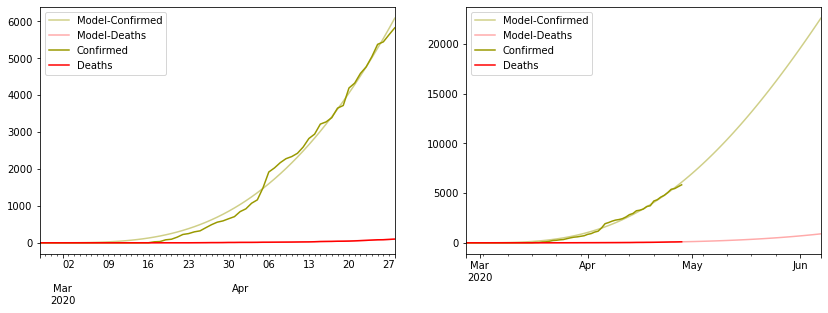

In [15]:
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('Punjab'))
opt_display_model_pr(df, stats)

In [16]:
df = get_time_series_province_pr('Punjab')
print('{} COVID-19 Prediction'.format('Punjab')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Punjab COVID-19 Prediction


,Confirmed,Deaths,Model-Confirmed,Model-Deaths
2020-04-08,"2,171",17,"1,869",16
2020-04-10,"2,336",19,"2,165",19
2020-04-12,"2,594",23,"2,487",24
2020-04-14,"2,945",28,"2,838",29
2020-04-16,"3,276",36,"3,216",35
2020-04-18,"3,649",41,"3,623",43
2020-04-20,"4,195",45,"4,058",51
2020-04-22,"4,590",58,"4,522",60
2020-04-24,"5,046",73,"5,016",71
2020-04-26,"5,446",83,"5,538",83


### ISLAMABAD

ICT of Pakistan COVID-19 Prediction


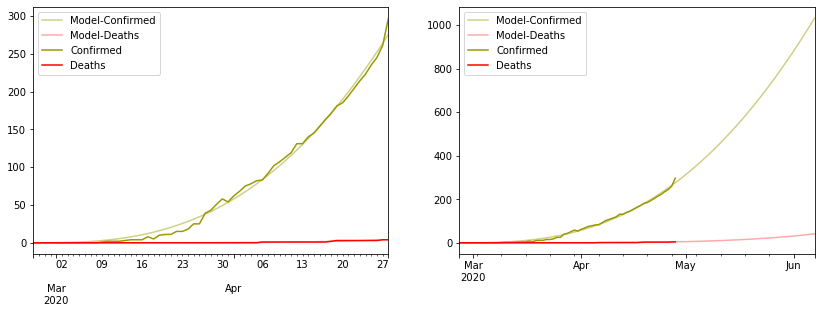

In [17]:
df = get_time_series_province_pr('ICT')
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('ICT'))
opt_display_model_pr(df, stats)

In [18]:
df = get_time_series_province_pr('ICT')
print('{} COVID-19 Prediction'.format('Islamabad')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Islamabad COVID-19 Prediction


,Confirmed,Deaths,Model-Confirmed,Model-Deaths
2020-04-08,102,1,96,1
2020-04-10,113,1,109,1
2020-04-12,131,1,123,1
2020-04-14,140,1,138,1
2020-04-16,154,1,154,2
2020-04-18,171,2,171,2
2020-04-20,185,3,190,2
2020-04-22,204,3,209,3
2020-04-24,223,3,230,3
2020-04-26,245,3,252,4


### Sindh

Sindh of Pakistan COVID-19 Prediction


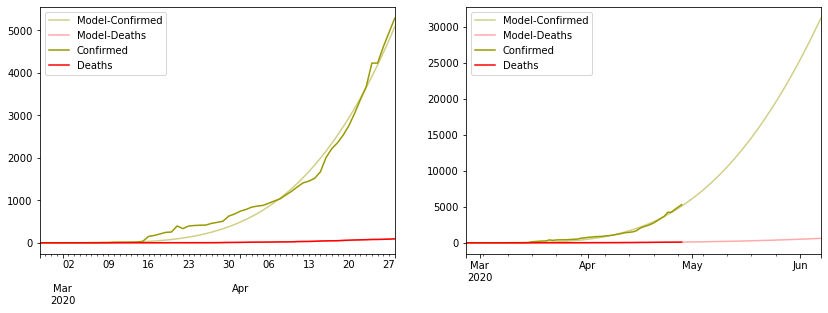

In [19]:
df = get_time_series_province_pr('Sindh')
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('Sindh'))
opt_display_model_pr(df, stats)

In [20]:
df = get_time_series_province_pr('Sindh')
print('{} COVID-19 Prediction'.format('Sindh')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Sindh COVID-19 Prediction


,Confirmed,Deaths,Model-Confirmed,Model-Deaths
2020-04-08,"1,036",20,"1,052",21
2020-04-10,"1,214",22,"1,277",25
2020-04-12,"1,411",30,"1,535",30
2020-04-14,"1,518",35,"1,829",36
2020-04-16,"2,008",45,"2,160",42
2020-04-18,"2,355",48,"2,532",49
2020-04-20,"2,764",61,"2,947",56
2020-04-22,"3,373",69,"3,408",65
2020-04-24,"4,232",78,"3,916",75
2020-04-26,"4,615",81,"4,475",85


### Balochistan

Balochistan of Pakistan COVID-19 Prediction


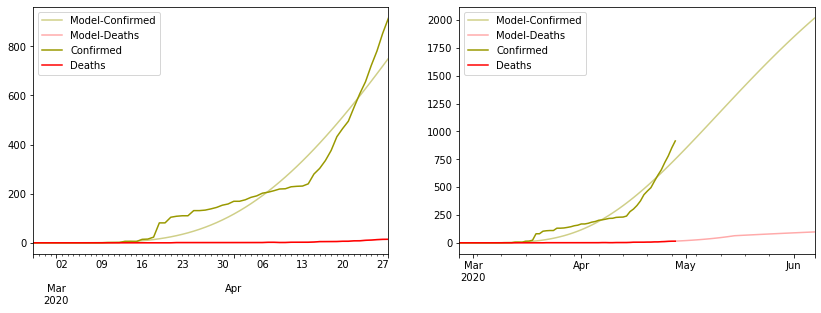

In [21]:
df = get_time_series_province_pr('Balochistan')
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('Balochistan'))
opt_display_model_pr(df, stats)

In [22]:
df = get_time_series_province_pr('Balochistan')
print('{} COVID-19 Prediction'.format('Balochistan')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Balochistan COVID-19 Prediction


,Confirmed,Deaths,Model-Confirmed,Model-Deaths
2020-04-08,212,2,228,1
2020-04-10,220,1,268,2
2020-04-12,230,2,311,2
2020-04-14,240,2,357,3
2020-04-16,303,5,406,4
2020-04-18,376,5,458,5
2020-04-20,465,6,512,6
2020-04-22,552,8,569,8
2020-04-24,656,10,628,10
2020-04-26,781,13,689,12


### KP

KPK of Pakistan COVID-19 Prediction


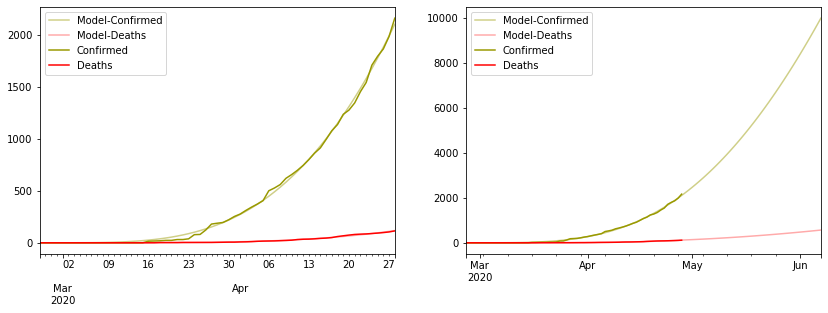

In [23]:
df = get_time_series_province_pr('KP')
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('KPK'))
opt_display_model_pr(df, stats)

In [24]:
df = get_time_series_province_pr('KP')
print('{} COVID-19 Prediction'.format('KPK')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

KPK COVID-19 Prediction


,Confirmed,Deaths,Model-Confirmed,Model-Deaths
2020-04-08,560,20,535,22
2020-04-10,656,25,633,27
2020-04-12,744,34,743,33
2020-04-14,862,38,865,40
2020-04-16,993,45,"1,000",47
2020-04-18,"1,137",60,"1,148",56
2020-04-20,"1,276",74,"1,310",66
2020-04-22,"1,453",83,"1,485",77
2020-04-24,"1,708",89,"1,676",89
2020-04-26,"1,864",98,"1,881",102


### AJK

AJK of Pakistan COVID-19 Prediction


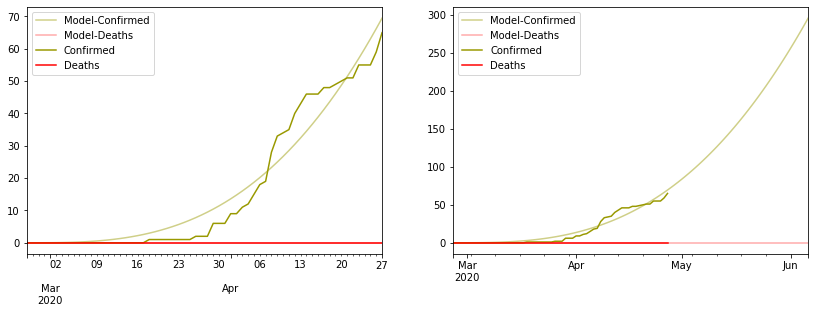

In [25]:
df = get_time_series_province_pr('AJK')
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('AJK'))
opt_display_model_pr(df, stats)

In [26]:
df = get_time_series_province_pr('AJK')
print('{} COVID-19 Prediction'.format('AJK')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 3 == 0].tail(30)

AJK COVID-19 Prediction


,Confirmed,Deaths,Model-Confirmed,Model-Deaths
2020-03-09,0,0,1,0
2020-03-12,0,0,1,0
2020-03-15,0,0,2,0
2020-03-18,1,0,3,0
2020-03-21,1,0,4,0
2020-03-24,1,0,6,0
2020-03-27,2,0,9,0
2020-03-30,6,0,11,0
2020-04-03,11,0,16,0
2020-04-06,18,0,20,0


### GB

GB of Pakistan COVID-19 Prediction


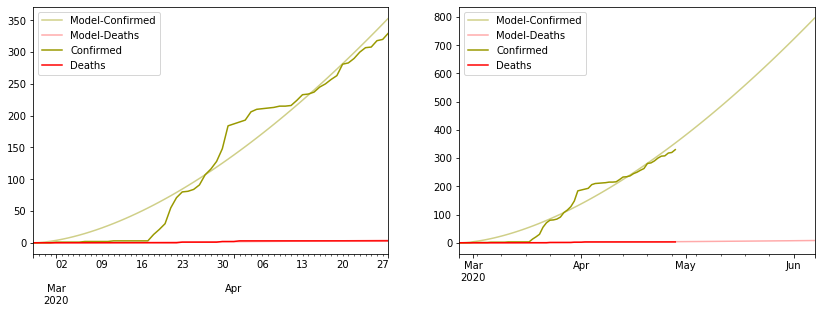

In [27]:
df = get_time_series_province_pr('GB')
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('GB'))
opt_display_model_pr(df, stats)

In [28]:
df = get_time_series_province_pr('GB')
print('{} COVID-19 Prediction'.format('GB')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

GB COVID-19 Prediction


,Confirmed,Deaths,Model-Confirmed,Model-Deaths
2020-04-08,213,3,186,2
2020-04-10,215,3,201,2
2020-04-12,224,3,217,2
2020-04-14,234,3,232,3
2020-04-16,245,3,248,3
2020-04-18,257,3,265,3
2020-04-20,281,3,282,3
2020-04-22,290,3,299,3
2020-04-24,307,3,317,3
2020-04-26,318,3,335,4


__Pakistan National Prediction__

Pakistan COVID-19 Prediction


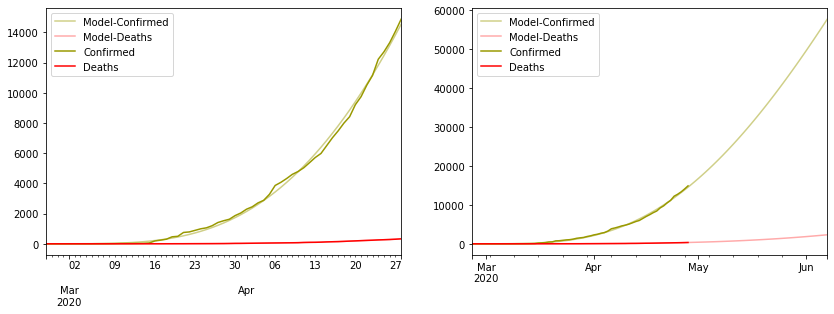

In [29]:
stats = []

df = fulltable_pr[['Region', 'Date', 'Confirmed', 'Deaths']].groupby('Date').sum()
print('Pakistan COVID-19 Prediction')
opt_display_model_pr(df, stats)

__Predictions Table__

In [30]:
model = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, model], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

,Confirmed,Deaths,Model-Confirmed,Model-Deaths
2020-04-08,"4,322",63,"4,066",64
2020-04-10,"4,788",71,"4,769",78
2020-04-12,"5,374",93,"5,546",94
2020-04-14,"5,985",107,"6,397",113
2020-04-16,"7,025",135,"7,324",134
2020-04-18,"7,993",159,"8,330",159
2020-04-20,"9,216",192,"9,414",186
2020-04-22,"10,513",224,"10,578",216
2020-04-24,"12,227",256,"11,822",250
2020-04-26,"13,328",281,"13,147",288
